# PSD

* **author**: steeve.laquitaine@epfl.ch
* date: 24.10.2024

* **Execution duration:** : 10 mins for 10 min recordings

* **Method**: 
    * PSD for first 10 minutes of recording. We will analyse the first 10 minutes as PSD is stable across time (compared with 40 min).
    * Welch method
        * 1Hz resolution, Hann window
    * The quality of PSD estimation from FFT depends on a unique parameter, the number of signal samples, N. The largest the number of samples, 
    and the better the frequency resolution, $f_r$, of the PSD, given sampling frequency $f_s$

    $$f_r = f_s / N$$

    * We estimated all PSDs over the same number of recording samples, to allow for a fair comparison of PSDs which frequency resolution depends on the signal's sample size. Small sample size degrades the frequency resolution of the PSD compared to large sample size, potentially masking significant features.
    * To minimize computational cost, we show the PSDs estimated from the same sample sizes corresponding to about 5 min of recordings, which was the shortest period that best preserved the features observed in the PSD estimated from the entire recordings.
    * We also estimated the PSD for all experiments' first 20 minutes (the largest common duration) and the entire recordings (see Supplementary figure).


    * Spiking band for power SNR: 300 - 6000 Hz

[TODO]:

* create a separate notebook for spiking band power.

## Setup

1. Compute power spectral data with: 

    sbatch src/pipes/validation/psd/mpi_npx_full.py  
    sbatch src/pipes/validation/psd/mpi_dense_full.py

2. Activate `spikeinterf..` venv

In [12]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import copy
import multiprocessing
import torch
import seaborn as sns
import pandas as pd
from scipy.stats import kruskal # stats
import scikit_posthocs as sp

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)


from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.validation import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
prm = dict()
prm["SFREQ_HV"] = 20000          # sampling frequency
prm["SFREQ_HS"] = 20000        # sampling frequency
prm["SFREQ_NV"] = 30000          # sampling frequency
prm["SFREQ_NS"] = 40000        # sampling frequency
prm["SFREQ_NB"] = 32000
prm["SFREQ_NE"] = 20000

# SETUP DATASETS

# neuropixels *********************

# neuropixels (Marques-Smith)
cfg_nv, _ = get_config("vivo_marques", "c26").values() 
RAW_PATH_nv = cfg_nv["probe_wiring"]["full"]["output"]
PREP_PATH_nv = cfg_nv["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_NV = cfg_nv["validation"]["psd"]["raw"]
PRE_PSD_PATH_NV = cfg_nv["validation"]["psd"]["preprocessed"]

# neuropixels (biophy. spont.)
cfg_ns, param_conf_ns = get_config("silico_neuropixels", "concatenated").values()
RAW_PATH_ns = cfg_ns["probe_wiring"]["full"]["output"]
PREP_PATH_ns = cfg_ns["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_NS = cfg_ns["validation"]["psd"]["raw"]
PRE_PSD_PATH_NS = cfg_ns["validation"]["psd"]["preprocessed"]

# neuropixels (evoked biophy.)
cfg_ne, _ = get_config("silico_neuropixels", "stimulus").values()
RAW_PATH_ne = cfg_ne["probe_wiring"]["full"]["output"]
PRE_PATH_NE = cfg_ne["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_NE = cfg_ne["validation"]["psd"]["raw"]
PRE_PSD_PATH_NE = cfg_ne["validation"]["psd"]["preprocessed"]

# neuropixels (synthetic, Buccino)
cfg_nb, param_conf_nb = get_config("buccino_2020", "2020").values()
RAW_PSD_PATH_NB = cfg_nb["validation"]["psd"]["raw"]
PRE_PSD_PATH_NB = cfg_nb["validation"]["psd"]["preprocessed"]

# custom *******************
# vivo (probe 1)
cfg_hv1, _ = get_config("vivo_horvath", "probe_1").values()
RAW_PATH_hv1 =  cfg_hv1["probe_wiring"]["full"]["output"]
PREP_PATH_hv1 = cfg_hv1["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV1 = cfg_hv1["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV1 = cfg_hv1["validation"]["psd"]["preprocessed"]
# probe 2
cfg_hv2, _ = get_config("vivo_horvath", "probe_2").values()
RAW_PATH_hv2 =  cfg_hv2["probe_wiring"]["full"]["output"]
PREP_PATH_hv2 = cfg_hv2["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV2 = cfg_hv2["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV2 = cfg_hv2["validation"]["psd"]["preprocessed"]
# probe 3
cfg_hv3, _ = get_config("vivo_horvath", "probe_3").values()
RAW_PATH_hv3 =  cfg_hv3["probe_wiring"]["full"]["output"]
PREP_PATH_hv3 = cfg_hv3["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HV3 = cfg_hv3["validation"]["psd"]["raw"]
PRE_PSD_PATH_HV3 = cfg_hv3["validation"]["psd"]["preprocessed"]
# biophy. model
# (probe 1)
cfg_hs1, _ = get_config("silico_horvath", "concatenated/probe_1").values()
RAW_PATH_hs1 = cfg_hs1["probe_wiring"]["full"]["output"]
PREP_PATH_hs1 = cfg_hs1["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS1 = cfg_hs1["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS1 = cfg_hs1["validation"]["psd"]["preprocessed"]
# probe 2
cfg_hs2, _ = get_config("silico_horvath", "concatenated/probe_2").values()
RAW_PATH_hs2 = cfg_hs2["probe_wiring"]["full"]["output"]
PREP_PATH_hs2 = cfg_hs2["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS2 = cfg_hs2["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS2 = cfg_hs2["validation"]["psd"]["preprocessed"]
# probe 3
cfg_hs3, _ = get_config("silico_horvath", "concatenated/probe_3").values()
RAW_PATH_hs3 = cfg_hs3["probe_wiring"]["full"]["output"]
PREP_PATH_hs3 = cfg_hs3["preprocessing"]["full"]["output"]["trace_file_path"]
RAW_PSD_PATH_HS3 = cfg_hs3["validation"]["psd"]["raw"]
PRE_PSD_PATH_HS3 = cfg_hs3["validation"]["psd"]["preprocessed"]


# FIGURE SETTINGS
FIG_SIZE = (1.5, 1.5)
# experiment colors
cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame



# parameterize
FIG_SIZE = (1, 1)
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 1.5,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.06,
}
pm_fit1 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}
pm_fit2 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-10-24 13:13:29,428 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-24 13:13:29,531 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-10-24 13:13:29,537 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-24 13:13:29,605 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-10-24 13:13:29,607 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-24 13:13:29,767 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-10-24 13:13:29,769 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-24 13:13:29,851 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-10-24 13:13:29,852 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-24 13:13:29,918 - root - utils.py - get_config - INFO - R

### Specs

In [3]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 72
available gpus: True


['              total        used        free      shared  buff/cache   available',
 'Mem:         772341       27734      743088         135        1518      742905',
 'Swap:             0           0           0']

### Custom functions

In [4]:
def print_slope(alpha):
    print(f"\u03B1={np.round(np.mean(alpha),1)}\u00B1{np.round(np.std(alpha),1)}")


def get_slope_df(data: list, exp, layer):
    df = pd.DataFrame()
    df["Alpha"] = np.negative(data)
    df["Experiment"] = exp
    df["Layer"] = layer
    return df

### (1s)Load dataset

* select first 10 min for speed

In [5]:
# Load traces
# neuropixels
# raw
RawNV = si.load_extractor(RAW_PATH_nv)
RawNS = si.load_extractor(RAW_PATH_ns)
RawNE = si.load_extractor(RAW_PATH_ne)
# preprocessed
PrepNV = si.load_extractor(PREP_PATH_nv)

# horvath
# raw (probe 1)
RawHV1 = si.load_extractor(RAW_PATH_hv1)
RawHS1 = si.load_extractor(RAW_PATH_hs1)
# raw (probe 2)
RawHV2 = si.load_extractor(RAW_PATH_hv2)
RawHS2 = si.load_extractor(RAW_PATH_hs2)
# raw (probe 3)
RawHV3 = si.load_extractor(RAW_PATH_hv3)
RawHS3 = si.load_extractor(RAW_PATH_hs3)
# preprocessed (probe 1)
PrepHV1 = si.load_extractor(PREP_PATH_hv1)
PrepHS1 = si.load_extractor(PREP_PATH_hs1)
# preprocessed (probe 2)
PrepHV2 = si.load_extractor(PREP_PATH_hv2)
PrepHS2 = si.load_extractor(PREP_PATH_hs2)
# preprocessed (probe 3)
PrepHV3 = si.load_extractor(PREP_PATH_hv3)
PrepHS3 = si.load_extractor(PREP_PATH_hs3)


# 4 - get good sites (in cortex) **********************
# neuropixels
lyrs = ["L1", "L2_3", "L4", "L5", "L6"]
# silico
site_ly_ns = RawNS.get_property("layers")
site_ly_ns[site_ly_ns == "L2"] = "L2_3"
site_ly_ns[site_ly_ns == "L3"] = "L2_3"
sites_ns = np.where(np.isin(site_ly_ns, lyrs))[0]
# evoked
site_ly_ne = RawNE.get_property("layers")
site_ly_ne[site_ly_ne == "L2"] = "L2_3"
site_ly_ne[site_ly_ne == "L3"] = "L2_3"
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]
# vivo
site_ly_nv = RawNV.get_property("layers")
sites_nv = np.where(np.isin(site_ly_nv, lyrs))[0]

# horvath
# silico
# probe 1 (select L1, L2/3)
site_ly_hs1 = RawHS1.get_property("layers")
site_ly_hs1 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2_3"]))[0]
# probe 2 (select L4 and L5)
site_ly_hs2 = RawHS2.get_property("layers")
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]
# probe 3 (select L6)
site_ly_hs3 = RawHS3.get_property("layers")
site_ly_hs3 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# vivo
# probe 1
site_ly_hv1 = RawHV1.get_property("layers")
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2_3"]))[0]
# probe 2
site_ly_hv2 = RawHV2.get_property("layers")
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]
# probe 3
site_ly_hv3 = RawHV3.get_property("layers")
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

# Load pre-computed PSDs (in cortex)
# neuropixels
# raw
psd_raw_nv = np.load(RAW_PSD_PATH_NV, allow_pickle=True).item()
psd_raw_ns = np.load(RAW_PSD_PATH_NS, allow_pickle=True).item()
psd_raw_ne = np.load(RAW_PSD_PATH_NE, allow_pickle=True).item()
psd_raw_nb = np.load(RAW_PSD_PATH_NB, allow_pickle=True).item()
# preprocessed
psd_pre_nv = np.load(PRE_PSD_PATH_NV, allow_pickle=True).item()
psd_pre_ns = np.load(PRE_PSD_PATH_NS, allow_pickle=True).item()
psd_pre_ne = np.load(PRE_PSD_PATH_NE, allow_pickle=True).item()
psd_pre_nb = np.load(PRE_PSD_PATH_NB, allow_pickle=True).item()

# custom (Horvath)
psd_raw_hv1 = np.load(RAW_PSD_PATH_HV1, allow_pickle=True).item()
psd_raw_hv2 = np.load(RAW_PSD_PATH_HV2, allow_pickle=True).item()
psd_raw_hv3 = np.load(RAW_PSD_PATH_HV3, allow_pickle=True).item()
psd_raw_hs1 = np.load(RAW_PSD_PATH_HS1, allow_pickle=True).item()
psd_raw_hs2 = np.load(RAW_PSD_PATH_HS2, allow_pickle=True).item()
psd_raw_hs3 = np.load(RAW_PSD_PATH_HS3, allow_pickle=True).item()
# preprocessed
psd_pre_hv1 = np.load(PRE_PSD_PATH_HV1, allow_pickle=True).item()
psd_pre_hv2 = np.load(PRE_PSD_PATH_HV2, allow_pickle=True).item()
psd_pre_hv3 = np.load(PRE_PSD_PATH_HV3, allow_pickle=True).item()
psd_pre_hs1 = np.load(PRE_PSD_PATH_HS1, allow_pickle=True).item()
psd_pre_hs2 = np.load(PRE_PSD_PATH_HS2, allow_pickle=True).item()
psd_pre_hs3 = np.load(PRE_PSD_PATH_HS3, allow_pickle=True).item()

# unit-test power spectral density resolutions
assert psd_raw_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_nv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_ns["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_ne["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_raw_nb["freq"][1] == 1.0, "psd resolution should be 1Hz"

assert psd_pre_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nv["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ns["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_ne["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_nb["freq"][1] == 1.0, "psd resolution should be 1Hz"

# All Layers


LFP band
α=-0.5±0.0
α=-0.1±0.0
α=0.0±0.0
α=-0.2±0.0
α=0.0±0.0

Spiking band
α=-1.4±0.3
α=-0.8±0.4
α=-0.4±0.3
α=-0.5±0.4
α=-0.2±0.2


n=272 sites
n=226 sites
n=202 sites
n=202 sites
n=297 sites

Power SNR
SNR: 20.694300123261844
SNR: 52.335680251857426
SNR: 19.701699067206892
SNR: 12.17861211984841
SNR: 348.558928956298
SNR: 125.574705274314


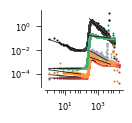

In [7]:
# horvath vivo (all layers)
# L1 (probe 1)
psd_pre_hv1_L1 = copy.copy(psd_pre_hv1)
psd_pre_hv1_L1["power"] = psd_pre_hv1["power"][site_ly_hv1[sites_hv1] == "L1", :]
# L23 (probe 1)
psd_pre_hv1_L23 = copy.copy(psd_pre_hv1)
psd_pre_hv1_L23["power"] = psd_pre_hv1["power"][site_ly_hv1[sites_hv1] == "L2_3", :]
# L4 (probe 2)
psd_pre_hv2_L4 = copy.copy(psd_pre_hv2)
psd_pre_hv2_L4["power"] = psd_pre_hv2["power"][site_ly_hv2[sites_hv2] == "L4", :]
# L5 (probe 2)
psd_pre_hv2_L5 = copy.copy(psd_pre_hv2)
psd_pre_hv2_L5["power"] = psd_pre_hv2["power"][site_ly_hv2[sites_hv2] == "L5", :]
# L6 (probe 3)
psd_pre_hv3_L6 = copy.copy(psd_pre_hv3)
psd_pre_hv3_L6["power"] = psd_pre_hv3["power"][site_ly_hv3[sites_hv3] == "L6", :]

# sites in target layers in each probe
psd_all_hv = dict()
psd_all_hv["power"] = np.vstack(
    [
        psd_pre_hv1_L1["power"],
        psd_pre_hv1_L23["power"],
        psd_pre_hv2_L4["power"],
        psd_pre_hv2_L5["power"],
        psd_pre_hv3_L6["power"],
    ]
)
psd_all_hv["freq"] = psd_pre_hv1["freq"]


# horvath biophy. spont. (all layers) **************************
# L1 (probe 1)
psd_pre_hs1_L1 = copy.copy(psd_pre_hs1)
psd_pre_hs1_L1["power"] = psd_pre_hs1["power"][site_ly_hs1[sites_hs1] == "L1", :]
# L23 (probe 1)
psd_pre_hs1_L23 = copy.copy(psd_pre_hs1)
psd_pre_hs1_L23["power"] = psd_pre_hs1["power"][site_ly_hs1[sites_hs1] == "L2_3", :]
# L4 (probe 2)
psd_pre_hs2_L4 = copy.copy(psd_pre_hs2)
psd_pre_hs2_L4["power"] = psd_pre_hs2["power"][site_ly_hs2[sites_hs2] == "L4", :]
# L5 (probe 2)
psd_pre_hs2_L5 = copy.copy(psd_pre_hs2)
psd_pre_hs2_L5["power"] = psd_pre_hs2["power"][site_ly_hs2[sites_hs2] == "L5", :]
# L6 (probe 3)
psd_pre_hs3_L6 = copy.copy(psd_pre_hs3)
psd_pre_hs3_L6["power"] = psd_pre_hs3["power"][site_ly_hs3[sites_hs3] == "L6", :]

# sites in target layers in each probe
psd_all_hs = dict()
psd_all_hs["power"] = np.vstack(
    [
        psd_pre_hs1_L1["power"],
        psd_pre_hs1_L23["power"],
        psd_pre_hs2_L4["power"],
        psd_pre_hs2_L5["power"],
        psd_pre_hs3_L6["power"],
    ]
)
psd_all_hs["freq"] = psd_pre_hs1["freq"]


FIG_SIZE = (1, 1)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.02]
YLIM_AX2 = [0, 0.08]
N_MAJOR_TICKS = 4
ALPHA = 0.7
fig, ax1 = plt.subplots(1, 1, figsize=FIG_SIZE)

# Fit panel ************************************************************

ax1, alphas_lfp_hv, alphas_spiking_hv = power.plot_fits_all(
    ax1, psd_all_hv, prm["SFREQ_HV"], cl["COLOR_HV"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_nv, alphas_spiking_nv = power.plot_fits_all(
    ax1, psd_pre_nv, prm["SFREQ_NV"], cl["COLOR_NV"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_ns, alphas_spiking_ns = power.plot_fits_all(
    ax1, psd_pre_ns, prm["SFREQ_NS"], cl["COLOR_NS"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_ne, alphas_spiking_ne = power.plot_fits_all(
    ax1, psd_pre_ne, prm["SFREQ_NE"], cl["COLOR_NE"], pm, pm_fit1, pm_fit2
)
ax1, alphas_lfp_hs, alphas_spiking_hs = power.plot_fits_all(
    ax1, psd_all_hs, prm["SFREQ_HS"], cl["COLOR_HS"], pm, pm_fit1, pm_fit2
)

# axes legend
# esthetics
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.spines[["top", "right"]].set_visible(False)
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax1.spines["left"].set_position(("axes", -0.05))

# report slopes
# lfp band
print("\nLFP band")
print_slope(alphas_lfp_hv)
print_slope(alphas_lfp_nv)
print_slope(alphas_lfp_ns)
print_slope(alphas_lfp_ne)
print_slope(alphas_lfp_hs)

# spiking band
print("\nSpiking band")
print_slope(alphas_spiking_hv)
print_slope(alphas_spiking_nv)
print_slope(alphas_spiking_ns)
print_slope(alphas_spiking_ne)
print_slope(alphas_spiking_hs)

# print sites
print("\n")
print(f"""n={psd_all_hv["power"].shape[0]} sites""")
print(f"""n={psd_pre_nv["power"].shape[0]} sites""")
print(f"""n={psd_pre_ns["power"].shape[0]} sites""")
print(f"""n={psd_pre_ne["power"].shape[0]} sites""")
print(f"""n={psd_all_hs["power"].shape[0]} sites""")


# SNR **************************
print("\nPower SNR")

out_hv = power.get_power_snr(psd_all_hv["power"], psd_all_hv["freq"], 300, 6000, 90)
out_nv = power.get_power_snr(psd_pre_nv["power"], psd_pre_nv["freq"], 300, 6000, 90)
out_ns = power.get_power_snr(psd_pre_ns["power"], psd_pre_ns["freq"], 300, 6000, 90)
out_ne = power.get_power_snr(psd_pre_ne["power"], psd_pre_ne["freq"], 300, 6000, 90)
out_hs = power.get_power_snr(psd_all_hs["power"], psd_all_hs["freq"], 300, 6000, 90)
out_nb = power.get_power_snr(psd_pre_nb["power"], psd_pre_nb["freq"], 300, 6000, 90)

# save
plt.savefig(
    "figures/6_supp/fig2/fig2G_pre_power_fit_all_sites.svg",
    **savefig_cfg,
)

## Compute data

In [8]:
d1 = power.get_psd_data_prepro(
    "L1",
    psd_pre_hv1,
    psd_pre_hs1,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv1[sites_hv1],
    site_ly_hs1[sites_hs1],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

d23 = power.get_psd_data_prepro(
    "L2_3",
    psd_pre_hv1,
    psd_pre_hs1,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv1[sites_hv1],
    site_ly_hs1[sites_hs1],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

d4 = power.get_psd_data_prepro(
    "L4",
    psd_pre_hv2,  # probe 2
    psd_pre_hs2,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv2[sites_hv2],  # probe 2
    site_ly_hs2[sites_hs2],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)
d5 = power.get_psd_data_prepro_layer_5(
    "L5",
    psd_pre_hv2,  # probe 2
    psd_pre_hs2,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    psd_pre_nb,
    site_ly_hv2[sites_hv2],  # probe 2
    site_ly_hs2[sites_hs2],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

d6 = power.get_psd_data_prepro(
    "L6",
    psd_pre_hv3,  # probe 3
    psd_pre_hs3,
    psd_pre_nv,
    psd_pre_ns,
    psd_pre_ne,
    site_ly_hv3[sites_hv3],  # probe 3
    site_ly_hs3[sites_hs3],
    site_ly_nv[sites_nv],
    site_ly_ns[sites_ns],
    site_ly_ne[sites_ne],
)

## Power law fits


LFP band
hv: α=-0.5±0.0
nv: α=-0.1±0.0
ns: α=0.0±0.0
ne: α=-0.2±0.0
hs: α=0.0±0.0

Spiking band
hv: α=-0.9±0.1
nv: α=-0.6±0.1
ns: α=-0.2±0.0
ne: α=-0.2±0.0
hs: α=-0.0±0.0

LFP band
hv: α=-0.5±0.0
nv: α=-0.1±0.0
ns: α=0.0±0.0
ne: α=-0.2±0.0
hs: α=0.0±0.0

Spiking band
hv: α=-1.4±0.3
nv: α=-0.6±0.2
ns: α=-0.2±0.1
ne: α=-0.2±0.1
hs: α=-0.1±0.1

LFP band
hv: α=-0.5±0.0
nv: α=-0.1±0.0
ns: α=0.0±0.0
ne: α=-0.2±0.0
hs: α=0.0±0.0

Spiking band
hv: α=-1.4±0.1
nv: α=-0.4±0.1
ns: α=-0.6±0.1
ne: α=-0.7±0.1
hs: α=-0.2±0.2

LFP band
α=-0.5±0.0
α=-0.1±0.0
α=0.0±0.0
α=-0.2±0.0
α=0.0±0.0
α=0.0±0.0

Spiking band
α=-1.6±0.3
α=-0.8±0.2
α=-0.9±0.2
α=-1.0±0.2
α=-0.2±0.1
α=-0.8±0.2

Power SNR
SNR: 11.35925172134442
SNR: 47.46660285035592
SNR: 56.48011961949342
SNR: 22.853918737870472
SNR: 217.46625804834912
SNR: 116.72186977416452

LFP band
hv: α=-0.5±0.0
nv: α=-0.1±0.0
ns: α=0.0±0.0
ne: α=-0.2±0.0
hs: α=0.0±0.0

Spiking band
hv: α=-1.3±0.2
nv: α=-1.0±0.5
ns: α=-0.2±0.1
ne: α=-0.3±0.2
hs: α=-0.3±0.3


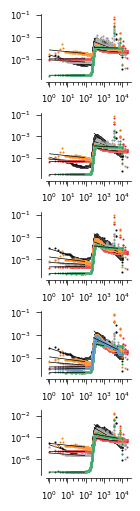

In [9]:
FIG_SIZE = (1.3, 5)

fig, axes = plt.subplots(5, 1, figsize=FIG_SIZE)

# L1
axes[0], dd1 = power.plot_power_law_fits(axes[0], d1, prm, cl, pm, pm_fit1, pm_fit2)
# L2/3
axes[1], dd23 = power.plot_power_law_fits(axes[1], d23, prm, cl, pm, pm_fit1, pm_fit2)
# L4
axes[2], dd4 = power.plot_power_law_fits(axes[2], d4, prm, cl, pm, pm_fit1, pm_fit2)
# L5
axes[3], dd5 = power.plot_power_law_fits_layer_5(
    axes[3], d5, prm, cl, pm, pm_fit1, pm_fit2
)
# L6
axes[4], dd6 = power.plot_power_law_fits(axes[4], d6, prm, cl, pm, pm_fit1, pm_fit2)

fig.tight_layout(**tight_layout_cfg)

# save
plt.savefig("figures/0_validation/4_power/fig2R/fig2R_pre_power_fit.svg", **savefig_cfg)

### Frequency scaling slope in spiking band

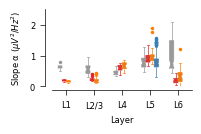

In [14]:
FIG_SIZE = (1.8, 1)

# layer 1
# neuropixels
df1 = get_slope_df(dd1["alphas_spiking_nv"], "MS", "L1")
df2 = get_slope_df(dd1["alphas_spiking_ns"], "NS", "L1")
df3 = get_slope_df(dd1["alphas_spiking_ne"], "NE", "L1")

# layer 2/3
df4 = get_slope_df(dd23["alphas_spiking_nv"], "MS", "L2/3")
df5 = get_slope_df(dd23["alphas_spiking_ns"], "NS", "L2/3")
df6 = get_slope_df(dd23["alphas_spiking_ne"], "NE", "L2/3")

# layer 4
df7 = get_slope_df(dd4["alphas_spiking_nv"], "MS", "L4")
df8 = get_slope_df(dd4["alphas_spiking_ns"], "NS", "L4")
df9 = get_slope_df(dd4["alphas_spiking_ne"], "NE", "L4")

# layer 5
df10 = get_slope_df(dd5["alphas_spiking_nv"], "MS", "L5")
df11 = get_slope_df(dd5["alphas_spiking_ns"], "NS", "L5")
df12 = get_slope_df(dd5["alphas_spiking_ne"], "NE", "L5")
df13 = get_slope_df(dd5["alphas_spiking_nb"], "NB", "L5")

# layer 6
df14 = get_slope_df(dd6["alphas_spiking_nv"], "MS", "L6")
df15 = get_slope_df(dd6["alphas_spiking_ns"], "NS", "L6")
df16 = get_slope_df(dd6["alphas_spiking_ne"], "NE", "L6")

plot_df_npx = pd.concat(
    [
        df1,
        df2,
        df3,
        df4,
        df5,
        df6,
        df7,
        df8,
        df9,
        df10,
        df11,
        df12,
        df13,
        df14,
        df15,
        df16,
    ]
)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot spiking band scaling
ax = sns.boxplot(
    ax=ax,
    data=plot_df_npx,
    x="Layer",
    y="Alpha",
    hue="Experiment",
    notch=True,
    hue_order=[
        "MS",
        "NS",
        "NE",
        "NB",
    ],
    palette=[
        cl["COLOR_NV"],
        cl["COLOR_NS"],
        cl["COLOR_NE"],
        cl["COLOR_NB"],
    ],
    width=0.6,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)
# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_ylabel("Slope \u03B1 ($\u03bcV^2 /Hz^2$)")
ax.set_ylim([0, 2.5])

# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            box.set_edgecolor(cl["COLOR_NV"])
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (NV)
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_NV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_NV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (NS)
            box.set_edgecolor(cl["COLOR_NS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NS"])
                ax.lines[k].set_mfc(cl["COLOR_NS"])
                ax.lines[k].set_mec(cl["COLOR_NS"])
            p += 1
        elif p in [10, 11, 12, 13, 14]:
            box.set_edgecolor(cl["COLOR_NE"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NE"])
                ax.lines[k].set_mfc(cl["COLOR_NE"])
                ax.lines[k].set_mec(cl["COLOR_NE"])
            p += 1
        elif p in [15]:
            box.set_edgecolor(cl["COLOR_NB"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NB"])
                ax.lines[k].set_mfc(cl["COLOR_NB"])
                ax.lines[k].set_mec(cl["COLOR_NB"])
            p += 1

# save
plt.savefig(
    "figures/0_validation/4_power/fig2T/fig2T_fscaling_spiking_npx.svg", **savefig_cfg
)

## Dense probe

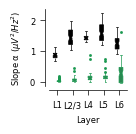

In [13]:
# layer 1
# neuropixels
df1 = get_slope_df(dd1["alphas_spiking_hv"], "H", "L1")
df2 = get_slope_df(dd1["alphas_spiking_hs"], "DS", "L1")

# layer 2/3
df3 = get_slope_df(dd23["alphas_spiking_hv"], "H", "L2/3")
df4 = get_slope_df(dd23["alphas_spiking_hs"], "DS", "L2/3")

# layer 4
df5 = get_slope_df(dd4["alphas_spiking_hv"], "H", "L4")
df6 = get_slope_df(dd4["alphas_spiking_hs"], "DS", "L4")

# layer 5
df7 = get_slope_df(dd5["alphas_spiking_hv"], "H", "L5")
df8 = get_slope_df(dd5["alphas_spiking_hs"], "DS", "L5")

# layer 6
df9 = get_slope_df(dd6["alphas_spiking_hv"], "H", "L6")
df10 = get_slope_df(dd6["alphas_spiking_hs"], "DS", "L6")

plot_df_dense = pd.concat(
    [
        df1,
        df2,
        df3,
        df4,
        df5,
        df6,
        df7,
        df8,
        df9,
        df10,
    ]
)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot spiking band scaling
ax = sns.boxplot(
    ax=ax,
    data=plot_df_dense,
    x="Layer",
    y="Alpha",
    hue="Experiment",
    notch=True,
    hue_order=[
        "H",
        "DS",
    ],
    palette=[
        cl["COLOR_HV"],
        cl["COLOR_HS"],
    ],
    width=0.5,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
        "markerfacecolor": "w",
        "markeredgecolor": (0.6, 0.6, 0.6),
        "markeredgewidth": 0.5,
    },
)

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_ylabel("Slope \u03B1 ($\u03bcV^2 /Hz^2$)")

# ax.set_ylim([0, 2.5])


# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (NV)
            box.set_edgecolor(cl["COLOR_HV"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_HV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_HV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (DS)
            box.set_edgecolor(cl["COLOR_HS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HS"])
                ax.lines[k].set_mfc(cl["COLOR_HS"])
                ax.lines[k].set_mec(cl["COLOR_HS"])
            p += 1

# save
plt.savefig(
    "figures/0_validation/4_power/fig2V/fig2V_fscaling_spiking_dense.svg", **savefig_cfg
)

### Hypothesis testing

In [16]:
def get_slope(df, exp, layer):
    return df[(df.Experiment == exp) & (df.Layer == layer)]["Alpha"].values


def get_kk(df, exp):
    """kruskall wallis test"""
    h, p = kruskal(
        get_slope(df, exp, "L1"),
        get_slope(df, exp, "L2/3"),
        get_slope(df, exp, "L4"),
        get_slope(df, exp, "L5"),
        get_slope(df, exp, "L6"),
    )

    print(f"H={h}, p={p}")
    print(f"""N_L1 = {len(get_slope(df, exp, "L1"))} sites""")
    print(f"""N_L23 = {len(get_slope(df, exp, "L2/3"))} sites""")
    print(f"""N_L4 = {len(get_slope(df, exp, "L4"))} sites""")
    print(f"""N_L5 = {len(get_slope(df, exp, "L5"))} sites""")
    print(f"""N_L6 = {len(get_slope(df, exp, "L6"))} sites""")


def get_posthoc_dunn_holm_sidak(df, exp):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        df (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_slope(df, exp, "L1"),
        get_slope(df, exp, "L2/3"),
        get_slope(df, exp, "L4"),
        get_slope(df, exp, "L5"),
        get_slope(df, exp, "L6"),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["L1", "L2/3", "L4", "L5", "L6"]
    df.index = ["L1", "L2/3", "L4", "L5", "L6"]
    return df

In [30]:
print(plot_df_npx.Experiment.unique())
print(plot_df_dense.Experiment.unique())

['MS' 'NS' 'NE' 'NB']
['H' 'DS']


#### H0: Does MS Spiking power change with depth?

In [26]:
get_kk(plot_df_npx, "MS")
get_posthoc_dunn_holm_sidak(plot_df_npx, "MS")

H=89.81934515492674, p=1.4384050892050125e-18
N_L1 = 10 sites
N_L23 = 42 sites
N_L4 = 34 sites
N_L5 = 42 sites
N_L6 = 98 sites


,L1,L2/3,L4,L5,L6
L1,1.000000,4.181089e-01,2.047426e-02,3.622361e-01,2.299625e-01
L2/3,0.418109,1.000000e+00,2.869168e-02,1.249054e-04,1.727561e-07
L4,0.020474,2.869168e-02,1.000000e+00,8.379398e-11,5.066577e-16
L5,0.362236,1.249054e-04,8.379398e-11,1.000000e+00,6.014022e-01
L6,0.229963,1.727561e-07,5.066577e-16,6.014022e-01,1.000000e+00


#### H0: Does NS Spiking power change with depth?

In [27]:
get_kk(plot_df_npx, "NS")
get_posthoc_dunn_holm_sidak(plot_df_npx, "NS")

H=144.00612780985, p=3.915685055818781e-30
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,4.175259e-01,0.000025,4.539957e-13,6.111005e-01
L2/3,4.175259e-01,1.000000e+00,0.000098,3.631692e-17,6.111005e-01
L4,2.473374e-05,9.819842e-05,1.000000,1.104051e-01,2.150108e-06
L5,4.539957e-13,3.631692e-17,0.110405,1.000000e+00,2.708125e-24
L6,6.111005e-01,6.111005e-01,0.000002,2.708125e-24,1.000000e+00


#### H0: Does E Spiking power change with depth?

In [29]:
get_kk(plot_df_npx, "NE")
get_posthoc_dunn_holm_sidak(plot_df_npx, "NE")

H=141.9951893283711, p=1.0554906645149783e-29
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,8.086052e-01,5.210791e-05,3.658374e-13,8.041977e-02
L2/3,8.086052e-01,1.000000e+00,8.416443e-07,3.507065e-24,3.441150e-02
L4,5.210791e-05,8.416443e-07,1.000000e+00,4.641977e-02,1.427464e-03
L5,3.658374e-13,3.507065e-24,4.641977e-02,1.000000e+00,5.756520e-17
L6,8.041977e-02,3.441150e-02,1.427464e-03,5.756520e-17,1.000000e+00


#### H0: Does Dense H Spiking power change with depth?

In [32]:
get_kk(plot_df_dense, "H")
get_posthoc_dunn_holm_sidak(plot_df_dense, "H")

H=130.04221135218108, p=3.8139534750075e-27
N_L1 = 36 sites
N_L23 = 60 sites
N_L4 = 20 sites
N_L5 = 88 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,1.334853e-14,5.786217e-10,7.542045e-26,6.956753e-07
L2/3,1.334853e-14,1.000000e+00,6.006069e-01,2.535614e-02,4.352752e-03
L4,5.786217e-10,6.006069e-01,1.000000e+00,3.882714e-01,1.741077e-02
L5,7.542045e-26,2.535614e-02,3.882714e-01,1.000000e+00,1.244091e-09
L6,6.956753e-07,4.352752e-03,1.741077e-02,1.244091e-09,1.000000e+00


#### H0: Does Dense DS Spiking power change with depth?

In [33]:
get_kk(plot_df_dense, "DS")
get_posthoc_dunn_holm_sidak(plot_df_dense, "DS")

H=55.99364433101698, p=2.0113378565045445e-11
N_L1 = 37 sites
N_L23 = 64 sites
N_L4 = 32 sites
N_L5 = 88 sites
N_L6 = 76 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,5.278048e-01,0.003492,5.299260e-08,0.000019
L2/3,5.278048e-01,1.000000e+00,0.020211,1.120631e-07,0.000097
L4,3.492152e-03,2.021113e-02,1.000000,4.241745e-01,0.583311
L5,5.299260e-08,1.120631e-07,0.424174,1.000000e+00,0.500167
L6,1.899459e-05,9.667730e-05,0.583311,5.001670e-01,1.000000


# References

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
